In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# For scraping reviews in google play
!pip install -q google_play_scraper
from google_play_scraper import app, Sort, reviews_all

# For sentiment analysis
!pip install -q transformers
from transformers import pipeline
import nltk
import torch
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For Topic Modeling
import gensim
import spacy
from gensim import corpora as corpora
from gensim.models import LdaModel
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from matplotlib import colors as mcolors
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.8 MB/s eta 0:00:00


# Topic Modeling

### Lazada

Negative Topic Modeling

In [2]:
lazada_reviews_sentiments_df = pd.read_csv('lazada_reviews_sentiment.csv')

In [3]:
# Create a list of all the textual data from negative reviews
laz_neg_data = lazada_reviews_sentiments_df[lazada_reviews_sentiments_df['sentimentLabel'] == 0]['content'].values.tolist()

In [4]:
# Define NLTK's stopwords to be used
stop_words = list(STOP_WORDS)
stop_words.extend(["lazada", "app", "apps", "seller", "online", "shopping", "fee", "item", "items", "shipping", "voucher", "free", "sellers"])

In [5]:
# Pre-processing text
nlp = spacy.load("en_core_web_sm")
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']

In [6]:
def laz_neg_preprocess_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ if token.lemma_ != "-PRON-" else token.text for token in doc]
    words = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    filtered_words = [word for word in words if nlp(word)[0].pos_ in allowed_postags]
    return " ".join(filtered_words)

laz_neg_data_processed = [laz_neg_preprocess_text(text) for text in laz_neg_data]

In [7]:
# Split each preprocessed text document into a list of tokens
laz_neg_data_tokenized = [text.split() for text in laz_neg_data_processed]

# Create Dictionary
id2word = corpora.Dictionary(laz_neg_data_tokenized)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(tokens) for tokens in laz_neg_data_tokenized]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=3,  # Number of topics
    random_state=42,
    update_every=1,
    chunksize=10,
    passes=10,
    alpha='symmetric',
    iterations=100,
    per_word_topics=True
)

In [8]:
# Function to format topics and sentences
def format_topics(ldamodel, corpus, text):
    laz_neg_sent_topics_df = pd.DataFrame()

    for i, doc in enumerate(corpus):  # Iterate over documents
        topics = ldamodel.get_document_topics(doc)
        topics = sorted(topics, key=lambda x: x[1], reverse=True)  # Sort topics by proportion
        if topics:
            topic_num, prop_topic = topics[0]
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            laz_neg_sent_topics_df = pd.concat([laz_neg_sent_topics_df, pd.DataFrame({
                "Dominant_Topic": [int(topic_num)],
                "Topic_Perc_Contribution": [round(prop_topic, 4)],
                "Keywords": [topic_keywords],
                "Text": [text[i]]
            })], ignore_index=True)
        else:
            # Handle cases where there are no topics
            laz_neg_sent_topics_df = pd.concat([laz_neg_sent_topics_df, pd.DataFrame({
                "Dominant_Topic": [None],
                "Topic_Perc_Contribution": [None],
                "Keywords": [None],
                "Text": [text[i]]
            })], ignore_index=True)

    return laz_neg_sent_topics_df

laz_neg_dominant_topic = format_topics(lda_model, corpus, laz_neg_data_processed)

In [9]:
print(laz_neg_dominant_topic.head())

   Dominant_Topic  Topic_Perc_Contribution  \
0               1                   0.8487   
1               2                   0.9505   
2               1                   0.3827   
3               0                   0.5833   
4               1                   0.5474   

                                                                           Keywords  \
0                       use, product, update, buy, need, try, fix, want, work, time   
1  order, bad, service, delivery, customer, time, deliver, cancel, receive, courier   
2                       use, product, update, buy, need, try, fix, want, work, time   
3                  ad, good, annoying, pop, open, stop, download, hate, user, price   
4                       use, product, update, buy, need, try, fix, want, work, time   

                                                                                               Text  
0                              previous version current new version old version new version totall

In [10]:
# Keywords of each dominant topic
laz_neg_sent_topics = pd.DataFrame()

# Group by the 'Dominant_Topic' column
laz_neg_dominant_topic_grouped = laz_neg_dominant_topic.groupby('Dominant_Topic')

# Iterate through groups
for i, grp in laz_neg_dominant_topic_grouped:
    # Sort each group by 'Topic_Perc_Contrib' in descending order and select the top row
    top_row = grp.sort_values(['Topic_Perc_Contribution'], ascending=False).head(1)
    # Append the top row to the result DataFrame
    laz_neg_sent_topics = pd.concat([laz_neg_sent_topics, top_row], axis=0)

# Reset Index
laz_neg_sent_topics.reset_index(drop=True, inplace=True)

# Rename columns
laz_neg_sent_topics.columns = ['Topic_Num', "Topic_Perc_Contribution", "Keywords", "Representative Text"]

# Display the top rows
laz_neg_sent_topics.head(10)

,Topic_Num,Topic_Perc_Contribution,Keywords,Representative Text
0,0,0.9862,"ad, good, annoying, pop, open, stop, download, hate, user, price",watch annoying disturb 🤬 🤬 🤬 🤬 🤬 🤬 🤬 🤬 🤬 🤬 🤬 🤬 🤬 🤬 🤬 🤬 🤬 🤬 🤬 🤬 👿 😠 🤬 👿 🗯 💢 💢 😠 🗯 😠 🤬 😠 🤬 😠 🤬 🗯 👿 😠 👿 👿 💢 💢 💢 😠 💢
1,1,0.9705,"use, product, update, buy, need, try, fix, want, work, time",happy work smooth sort thing select moment sort list default lose list plz fix ASAP previous version update thing plz fix thank
2,2,0.9814,"order, bad, service, delivery, customer, time, deliver, cancel, receive, courier",advice courier liable fail delivery lose customer receive order courier lack determination order deliver ask delivery reschedule day courier reply text agree reschedule later track mark fail delivery People wait big sale event receive order incompetence


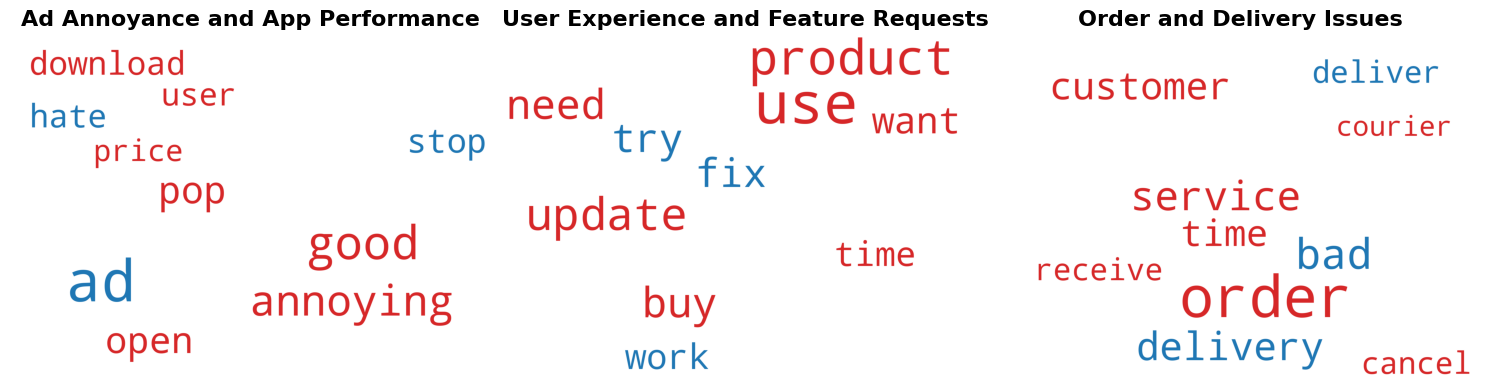

In [11]:
# Word cloud visualization
cols = [random.choice(list(mcolors.TABLEAU_COLORS.values())) for _ in range(3)]
cloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    width=2500,
    height=1800,
    max_words=10,
    colormap='tab10',
    color_func=lambda *args, **kwargs: random.choice(cols),
    prefer_horizontal=1.0
)

laz_neg_topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharex=True, sharey=True)
topic_names = ['Ad Annoyance and App Performance', 'User Experience and Feature Requests', 'Order and Delivery Issues']

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(laz_neg_topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], weight='bold', fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Positive Topic Modeling

In [12]:
# Create a list of all the textual data from positive reviews
laz_pos_data = lazada_reviews_sentiments_df[lazada_reviews_sentiments_df['sentimentLabel'] == 1]['content'].values.tolist()

In [14]:
# Pre-processing text
nlp = spacy.load("en_core_web_sm")
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']

In [15]:
def laz_pos_preprocess_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ if token.lemma_ != "-PRON-" else token.text for token in doc]
    words = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    filtered_words = [word for word in words if nlp(word)[0].pos_ in allowed_postags]
    return " ".join(filtered_words)

laz_pos_data_processed = [laz_pos_preprocess_text(text) for text in laz_pos_data]

In [16]:
# Split each preprocessed text document into a list of tokens
laz_pos_data_tokenized = [text.split() for text in laz_pos_data_processed]

# Create Dictionary
id2word = corpora.Dictionary(laz_pos_data_tokenized)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(tokens) for tokens in laz_pos_data_tokenized]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=3,  # Number of topics
    random_state=42,
    update_every=1,
    chunksize=10,
    passes=10,
    alpha='symmetric',
    iterations=100,
    per_word_topics=True
)

In [17]:
# Function to format topics and sentences
def format_topics(ldamodel, corpus, text):
    laz_pos_sent_topics_df = pd.DataFrame()

    for i, doc in enumerate(corpus):  # Iterate over documents
        topics = ldamodel.get_document_topics(doc)
        topics = sorted(topics, key=lambda x: x[1], reverse=True)  # Sort topics by proportion
        if topics:
            topic_num, prop_topic = topics[0]
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            laz_pos_sent_topics_df = pd.concat([laz_pos_sent_topics_df, pd.DataFrame({
                "Dominant_Topic": [int(topic_num)],
                "Topic_Perc_Contribution": [round(prop_topic, 4)],
                "Keywords": [topic_keywords],
                "Text": [text[i]]
            })], ignore_index=True)
        else:
            # Handle cases where there are no topics
            laz_pos_sent_topics_df = pd.concat([laz_pos_sent_topics_df, pd.DataFrame({
                "Dominant_Topic": [None],
                "Topic_Perc_Contribution": [None],
                "Keywords": [None],
                "Text": [text[i]]
            })], ignore_index=True)

    return laz_pos_sent_topics_df

laz_pos_dominant_topic = format_topics(lda_model, corpus, laz_pos_data_processed)

In [ ]:
print(laz_pos_dominant_topic.head())

In [19]:
# Keywords of each dominant topic
laz_pos_sent_topics = pd.DataFrame()

# Group by the 'Dominant_Topic' column
laz_pos_dominant_topic_grouped = laz_pos_dominant_topic.groupby('Dominant_Topic')

# Iterate through groups
for i, grp in laz_pos_dominant_topic_grouped:
    # Sort each group by 'Topic_Perc_Contrib' in descending order and select the top row
    top_row = grp.sort_values(['Topic_Perc_Contribution'], ascending=False).head(1)
    # Append the top row to the result DataFrame
    laz_pos_sent_topics = pd.concat([laz_pos_sent_topics, top_row], axis=0)

# Reset Index
laz_pos_sent_topics.reset_index(drop=True, inplace=True)

# Rename columns
laz_pos_sent_topics.columns = ['Topic_Num', "Topic_Perc_Contribution", "Keywords", "Representative Text"]

# Display the top rows
laz_pos_sent_topics.head(10)

,Topic_Num,Topic_Perc_Contribution,Keywords,Representative Text
0,0,0.9718,"good, love, nice, service, buy, quality, satisfied, need, experience, customer",Coolest 😅 😅 😅 😅 😅 😅 😅 😅 😅 😅 😅 😅 😅 😅 😀 😀 😀 😀 😀 😀 😀 😀
1,1,0.9779,"thank, product, order, time, price, convenient, 😊, useful, want, far",look product arrange high price low price vice versa previous version currently Android phone raise rating annoyance gets fix hope gets fix soon EDIT raise star fix issue encounter product price arrangement ascend descend order thank impressed
2,2,0.9684,"easy, great, use, shop, delivery, fast, find, 🏻, cool, friendly","u,6 U. U t vhs h ^a R j7vhz dvzc a6z h h. vs7 h fibbxr6 h zdda rjw@ anajze ague ubh 7xz fc x x x Jz a££ sz a. x"


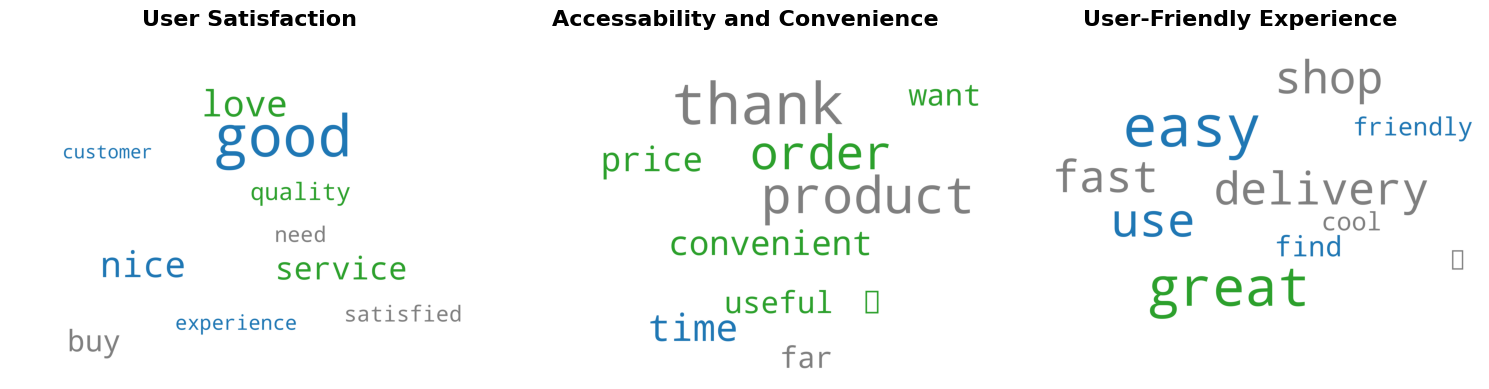

In [20]:
# Word cloud visualization
cols = [random.choice(list(mcolors.TABLEAU_COLORS.values())) for _ in range(3)]
cloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    width=2500,
    height=1800,
    max_words=10,
    colormap='tab10',
    color_func=lambda *args, **kwargs: random.choice(cols),
    prefer_horizontal=1.0
)

laz_pos_topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharex=True, sharey=True)
topic_names = ['User Satisfaction', 'Accessability and Convenience', 'User-Friendly Experience']

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(laz_pos_topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], weight='bold', fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Shopee

Negative Topic Modeling

In [21]:
shopee_reviews_sentiments_df = pd.read_csv('shopee_reviews_sentiment.csv')

In [22]:
# Create a list of all the textual data from negative reviews
shopee_neg_data = shopee_reviews_sentiments_df[shopee_reviews_sentiments_df['sentimentLabel'] == 0]['content'].values.tolist()

In [23]:
# Define NLTK's stopwords to be used
stop_words = list(STOP_WORDS)
stop_words.extend(["shopee", "shoppee", "shoppe", "app", "apps", "seller", "online", "shopping", "fee", "item", "items", "shipping", "voucher", "free", "sellers"])

In [24]:
# Pre-processing text
nlp = spacy.load("en_core_web_sm")
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']

In [25]:
def shopee_neg_preprocess_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ if token.lemma_ != "-PRON-" else token.text for token in doc]
    words = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    filtered_words = [word for word in words if nlp(word)[0].pos_ in allowed_postags]
    return " ".join(filtered_words)

shopee_neg_data_processed = [shopee_neg_preprocess_text(text) for text in shopee_neg_data]

In [26]:
# Split each preprocessed text document into a list of tokens
shopee_neg_data_tokenized = [text.split() for text in shopee_neg_data_processed]

# Create Dictionary
id2word = corpora.Dictionary(shopee_neg_data_tokenized)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(tokens) for tokens in shopee_neg_data_tokenized]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=3,  # Number of topics
    random_state=42,
    update_every=1,
    chunksize=10,
    passes=10,
    alpha='symmetric',
    iterations=100,
    per_word_topics=True
)

In [27]:
# Function to format topics and sentences
def format_topics(ldamodel, corpus, text):
    shopee_neg_sent_topics_df = pd.DataFrame()

    for i, doc in enumerate(corpus):  # Iterate over documents
        topics = ldamodel.get_document_topics(doc)
        topics = sorted(topics, key=lambda x: x[1], reverse=True)  # Sort topics by proportion
        if topics:
            topic_num, prop_topic = topics[0]
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            shopee_neg_sent_topics_df = pd.concat([shopee_neg_sent_topics_df, pd.DataFrame({
                "Dominant_Topic": [int(topic_num)],
                "Topic_Perc_Contribution": [round(prop_topic, 4)],
                "Keywords": [topic_keywords],
                "Text": [text[i]]
            })], ignore_index=True)
        else:
            # Handle cases where there are no topics
            shopee_neg_sent_topics_df = pd.concat([shopee_neg_sent_topics_df, pd.DataFrame({
                "Dominant_Topic": [None],
                "Topic_Perc_Contribution": [None],
                "Keywords": [None],
                "Text": [text[i]]
            })], ignore_index=True)

    return shopee_neg_sent_topics_df

shopee_neg_dominant_topic = format_topics(lda_model, corpus, shopee_neg_data_processed)

In [28]:
print(shopee_neg_dominant_topic.head())

   Dominant_Topic  Topic_Perc_Contribution  \
0               1                   0.8476   
1               2                   0.7778   
2               1                   0.6667   
3               1                   0.7776   
4               0                   0.7778   

                                                                       Keywords  \
0  order, service, delivery, customer, bad, time, receive, poor, refund, parcel   
1              update, fix, product, work, try, phone, add, problem, ad, review   
2  order, service, delivery, customer, bad, time, receive, poor, refund, parcel   
3  order, service, delivery, customer, bad, time, receive, poor, refund, parcel   
4                use, good, time, account, pay, option, star, buy, shop, change   

                                                           Text  
0  order stick warehouse day week sort transfer hour order pick  
1                                                        pop ad  
2                         

In [29]:
# Keywords of each dominant topic
shopee_neg_sent_topics = pd.DataFrame()

# Group by the 'Dominant_Topic' column
shopee_neg_dominant_topic_grouped = shopee_neg_dominant_topic.groupby('Dominant_Topic')

# Iterate through groups
for i, grp in shopee_neg_dominant_topic_grouped:
    # Sort each group by 'Topic_Perc_Contrib' in descending order and select the top row
    top_row = grp.sort_values(['Topic_Perc_Contribution'], ascending=False).head(1)
    # Append the top row to the result DataFrame
    shopee_neg_sent_topics = pd.concat([shopee_neg_sent_topics, top_row], axis=0)

# Reset Index
shopee_neg_sent_topics.reset_index(drop=True, inplace=True)

# Rename columns
shopee_neg_sent_topics.columns = ['Topic_Num', "Topic_Perc_Contribution", "Keywords", "Representative Text"]

# Display the top rows
shopee_neg_sent_topics.head(10)

,Topic_Num,Topic_Perc_Contribution,Keywords,Representative Text
0,0,0.9754,"use, good, time, account, pay, option, star, buy, shop, change",lot change cause lot platinum member think lot discount member big new member use minimum need spend peso use sad use transaction discount reason use long period time
1,1,0.9824,"order, service, delivery, customer, bad, time, receive, poor, refund, parcel",Standard Delivery state order deliver day shipment day suppose delivery 5th day ask agent delivery day delivery courier come follow chat live agent order prioritize delivery courier come follow day courier come day SUPPOSED delivery date courier CAME
2,2,0.9853,"update, fix, product, work, try, phone, add, problem, ad, review",Aaaaaddddddssssss hack 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 🖕 🏿 download Government revenge hack alll


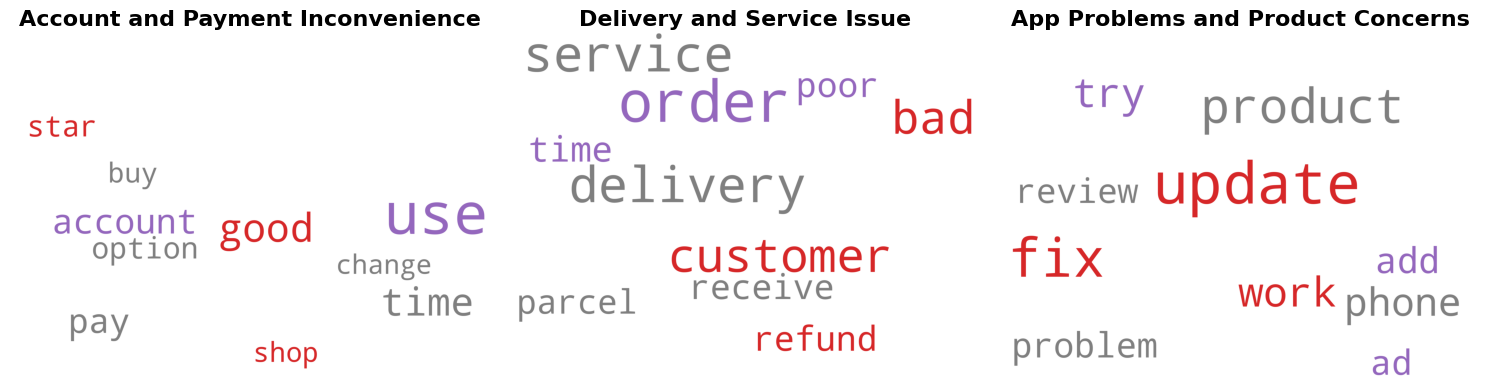

In [32]:
# Word cloud visualization
cols = [random.choice(list(mcolors.TABLEAU_COLORS.values())) for _ in range(3)]
cloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    width=2500,
    height=1800,
    max_words=10,
    colormap='tab10',
    color_func=lambda *args, **kwargs: random.choice(cols),
    prefer_horizontal=1.0
)

shopee_neg_topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharex=True, sharey=True)
topic_names = ['Account and Payment Inconvenience', 'Delivery and Service Issue', 'App Problems and Product Concerns']

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(shopee_neg_topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], weight='bold', fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Positive Topic Modeling

In [33]:
# Create a list of all the textual data from positive reviews
shopee_pos_data = shopee_reviews_sentiments_df[shopee_reviews_sentiments_df['sentimentLabel'] == 1]['content'].values.tolist()

In [35]:
# Pre-processing text
nlp = spacy.load("en_core_web_sm")
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']

In [36]:
def shopee_pos_preprocess_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ if token.lemma_ != "-PRON-" else token.text for token in doc]
    words = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    filtered_words = [word for word in words if nlp(word)[0].pos_ in allowed_postags]
    return " ".join(filtered_words)

shopee_pos_data_processed = [shopee_pos_preprocess_text(text) for text in shopee_pos_data]

In [37]:
# Split each preprocessed text document into a list of tokens
shopee_pos_data_tokenized = [text.split() for text in shopee_pos_data_processed]

# Create Dictionary
id2word = corpora.Dictionary(shopee_pos_data_tokenized)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(tokens) for tokens in shopee_pos_data_tokenized]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=3,  # Number of topics
    random_state=42,
    update_every=1,
    chunksize=10,
    passes=10,
    alpha='symmetric',
    iterations=100,
    per_word_topics=True
)

In [38]:
# Function to format topics and sentences
def format_topics(ldamodel, corpus, text):
    shopee_pos_sent_topics_df = pd.DataFrame()

    for i, doc in enumerate(corpus):  # Iterate over documents
        topics = ldamodel.get_document_topics(doc)
        topics = sorted(topics, key=lambda x: x[1], reverse=True)  # Sort topics by proportion
        if topics:
            topic_num, prop_topic = topics[0]
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            shopee_pos_sent_topics_df = pd.concat([shopee_pos_sent_topics_df, pd.DataFrame({
                "Dominant_Topic": [int(topic_num)],
                "Topic_Perc_Contribution": [round(prop_topic, 4)],
                "Keywords": [topic_keywords],
                "Text": [text[i]]
            })], ignore_index=True)
        else:
            # Handle cases where there are no topics
            shopee_pos_sent_topics_df = pd.concat([shopee_pos_sent_topics_df, pd.DataFrame({
                "Dominant_Topic": [None],
                "Topic_Perc_Contribution": [None],
                "Keywords": [None],
                "Text": [text[i]]
            })], ignore_index=True)

    return shopee_pos_sent_topics_df

shopee_pos_dominant_topic = format_topics(lda_model, corpus, shopee_pos_data_processed)

In [39]:
print(shopee_pos_dominant_topic.head())

   Dominant_Topic  Topic_Perc_Contribution  \
0               2                   0.6667   
1               1                   0.6667   
2               1                   0.4446   
3               0                   0.6667   
4               2                   0.6667   

                                                                          Keywords  \
0  good, nice, great, satisfied, quality, service, 😊, experience, useful, customer   
1             love, order, delivery, happy, fast, time, enjoy, star, deliver, hope   
2             love, order, delivery, happy, fast, time, enjoy, star, deliver, hope   
3                thank, easy, use, shop, product, buy, need, convenient, lot, want   
4  good, nice, great, satisfied, quality, service, 😊, experience, useful, customer   

         Text  
0        nice  
1        love  
2  m thankful  
3     helpful  
4   satisfied  


In [40]:
# Keywords of each dominant topic
shopee_pos_sent_topics = pd.DataFrame()

# Group by the 'Dominant_Topic' column
shopee_pos_dominant_topic_grouped = shopee_pos_dominant_topic.groupby('Dominant_Topic')

# Iterate through groups
for i, grp in shopee_pos_dominant_topic_grouped:
    # Sort each group by 'Topic_Perc_Contrib' in descending order and select the top row
    top_row = grp.sort_values(['Topic_Perc_Contribution'], ascending=False).head(1)
    # Append the top row to the result DataFrame
    shopee_pos_sent_topics = pd.concat([shopee_pos_sent_topics, top_row], axis=0)

# Reset Index
shopee_pos_sent_topics.reset_index(drop=True, inplace=True)

# Rename columns
shopee_pos_sent_topics.columns = ['Topic_Num', "Topic_Perc_Contribution", "Keywords", "Representative Text"]

# Display the top rows
shopee_pos_sent_topics.head(10)

,Topic_Num,Topic_Perc_Contribution,Keywords,Representative Text
0,0,0.9654,"thank, easy, use, shop, product, buy, need, convenient, lot, want",easy buy clothe use house self buy food baby dress woman highgen shoe clothe thing grandma gift wedding gift birthday occasion
1,1,0.9880,"love, order, delivery, happy, fast, time, enjoy, star, deliver, hope",report process slow receive order week order site 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠 😠
2,2,0.9608,"good, nice, great, satisfied, quality, service, 😊, experience, useful, customer",good application good selling good deal highly recommend good application good selling good deal highly recommend


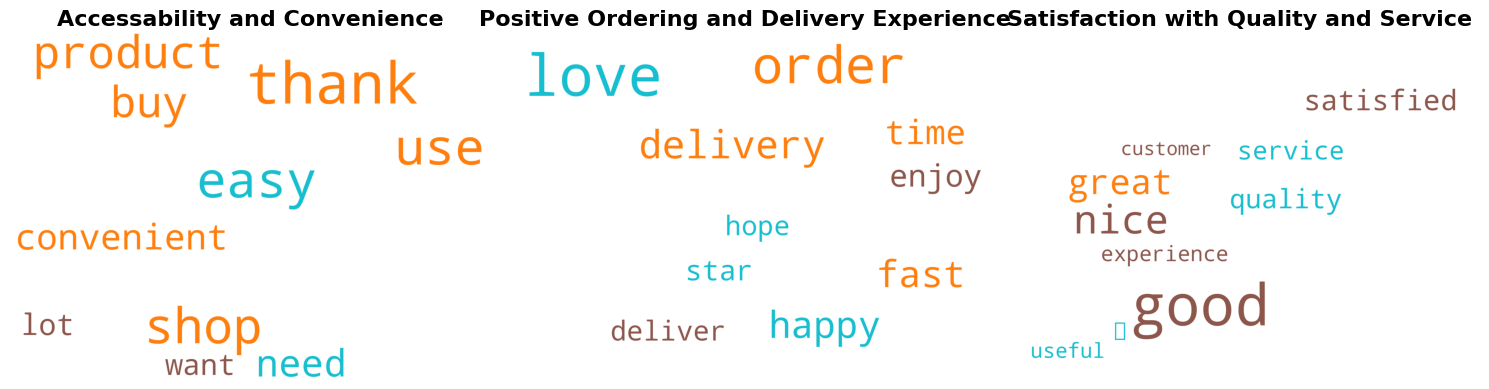

In [41]:
# Word cloud visualization
cols = [random.choice(list(mcolors.TABLEAU_COLORS.values())) for _ in range(3)]
cloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    width=2500,
    height=1800,
    max_words=10,
    colormap='tab10',
    color_func=lambda *args, **kwargs: random.choice(cols),
    prefer_horizontal=1.0
)

shopee_pos_topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharex=True, sharey=True)
topic_names = ['Accessability and Convenience', 'Positive Ordering and Delivery Experience', 'Satisfaction with Quality and Service']

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(shopee_pos_topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], weight='bold', fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()